In [1]:
from constants import *
from datasets import load_dataset
from collections import defaultdict
import json
import re
import ast
import metrics
from constants import *
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import ast
from collections import defaultdict
from datasets import load_dataset

/home/jmire/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
ds = load_dataset(AOKVQA_DATASET_NAME)
splits = ['validation']

for split in splits:
    # Dictionary to store gold references
    gold_df = defaultdict(dict)
    qid_to_mc_choices = {}

    for ex in ds[split]:
        # Extract correct answer and direct answers
        gold_df[ex['question_id']] = {
            'mc': ex['choices'][ex['correct_choice_idx']],
            'da': ast.literal_eval(ex['direct_answers'])
        }
        
        # Store all multiple-choice options
        qid_to_mc_choices[ex['question_id']] = ex['choices']

    # Sort gold_df by question_id and write to JSONL
    with open(f'{RESULTS_DIR}/gold_{split}.jsonl', "w") as f:
        for key in sorted(gold_df.keys()):
            json_line = json.dumps({key: gold_df[key]})
            f.write(json_line + "\n")

In [3]:
# Process raw result files into standard format

def sort_and_save_jsonl(records, output_file, sort_key='qid'):
    """
    Sorts a list of JSONL records by a specified key and writes them to a JSONL file.
    
    Args:
        records (list of dict): The list of records to sort and save.
        output_file (str): Path to the output JSONL file.
        sort_key (str): The key to sort records by (default is 'qid').
    """
    # Sort the records by the specified key
    records.sort(key=lambda x: x[sort_key])
    
    # Write sorted records to JSONL file
    with open(output_file, 'w') as f:
        for record in records:
            f.write(json.dumps(record) + '\n')


def joel_fmt(fname):
    input_file = f'{RESULTS_DIR}/raw/joel/{fname}'
    output_file = f"{RESULTS_DIR}/formatted/{fname.replace('.json', '')}.jsonl"
    records = []
    
    with open(input_file, 'r') as f:
        data = json.load(f)
        for id, entry in data.items():
            record = {
                "qid": id,
                "da": entry.get('direct_answer'),
                "mc": entry.get('multiple_choice')
            }
            records.append(record)
    
    # Sort and save records using the helper function
    sort_and_save_jsonl(records, output_file)

def nihali_fmt(fname):
    records = []
    out_dict = defaultdict(lambda: defaultdict(str))
    
    for task in ['da', 'mc']:
        for result in ['correct', 'incorrect']:
            input_file = f'{RESULTS_DIR}/raw/nihali/{fname}_{task}_{result}.json'
            with open(input_file, 'r') as f:
                data = json.load(f)
                for qid, entry in data.items():
                    out_dict[qid]['qid'] = qid
                    out_dict[qid][task] = entry.get('prediction')
    
    for qid, val in out_dict.items():
        record = {
            "qid": val['qid'],
            "da": val['da'],
            "mc": val['mc']
        }
        records.append(record)
    
    # Sort and save records using the helper function
    output_file = f"{RESULTS_DIR}/formatted/{fname}.jsonl"
    sort_and_save_jsonl(records, output_file)

def mingqian_fmt(fname):
    records = []
    da_input_file = f'{RESULTS_DIR}/raw/mingqian/{fname}_da.json'
    mc_input_file = f'{RESULTS_DIR}/raw/mingqian/{fname}_mc.json'
    
    with open(da_input_file, 'r') as da_f, open(mc_input_file, 'r') as mc_f:
        da_data = json.load(da_f)
        mc_data = json.load(mc_f)
        for da_entry, mc_entry in zip(da_data, mc_data):
            qid = da_entry['question_id']
            match = re.search(r'\d+', mc_entry['answer'])
            mc_choice_idx = int(match.group()) - 1 if match else None
            record = {
                "qid": qid,
                "da": da_entry['answer'],
                "mc": qid_to_mc_choices[qid][mc_choice_idx] if mc_choice_idx is not None and 0 <= mc_choice_idx <= 3 else ""
            }
            records.append(record)
    
    # Sort and save records using the helper function
    output_file = f"{RESULTS_DIR}/formatted/{fname}.jsonl"
    sort_and_save_jsonl(records, output_file)

for model, val in MODELS.items():
  dir = val['raw_results_dir']
  fname = val['raw_results_fname']
  if dir == 'joel':
    joel_fmt(fname)
  elif dir == 'nihali':
    nihali_fmt(fname)
  elif dir == 'mingqian':
    mingqian_fmt(fname)

mc


['person', 'thirty', 'dirty', 'icing', 'keyboard', 'error', 'cutting hair', 'minimalist', 'crouching', 'denim', 'no country information available', 'candle', 'error', 'lettuce', 'no item found', 'angus', 'american', 'books', 'afternoon', 'jump', 'date', 'fondant', 'chef', 'frisbee', 'human', 'ski resort', 'air', 'north', 'air traffic', 'you need to specify which', 'error multiple or no ingredients found', 'error', 'street festival', 'pillow', 'error', 'cricket', 'body wash', 'wii boxing', 'bunt', 'fleeing', '', 'savanna', 'metal', 'dog', 'bathroom', 'error', 'fruit', 'storage', 'tie dye', 'asian', 'decoration', 'visibility', 'arguing', 'melted ice cream', 'to eat', 'laundry', 'city', 'yes', 'kitchen', 'social', 'dirt bikes', 'new york', 'gin', 'bicycle', 'east', 'spain', 'christmas', 'elephant', 'tanks', 'tennis balls', 'crashing', '', 'soup', 'twowheeler', 'its for safety', 'post', 'desk', 'stone', 'streep', 'sprinkled', '', 'serena williams', 'travel', 'kite', 'phone', 'mushrooms', '

/tmp/ipykernel_3003756/3215461061.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)


                      model task   bleu  bertscore  mc_acc
0           BLIP 2 OPT 2.7B   mc  0.476      0.599   0.215
1                  ViperGPT   mc  0.042      0.693   0.409
2              LLaVA-1.5-7b   mc  0.824      0.851   0.691
3       CLIP (Zero Shot) MM   mc  0.574      0.752   0.462
4     CLIP (Contrastive) MM   mc  0.623      0.775   0.515
5      CLIP (Classifier) MM   mc  0.643      0.723   0.398
6                   ClipCap   mc  0.654      0.776   0.516
7     ClipCap (with RN50x4)   mc  0.688      0.755   0.468
8       Llama 3 8B Instruct   mc  0.004      0.598   0.212
9   CLIP (Contrastive) UM-T   mc  0.547      0.701   0.359
10   CLIP (Classifier) UM-T   mc  0.522      0.685   0.318
11          BERT Classifier   mc  0.521      0.683   0.312
12    CLIP (Zero Shot) UM-I   mc  0.636      0.789   0.544
13  CLIP (Contrastive) UM-I   mc  0.636      0.789   0.544
14   CLIP (Classifier) UM-I   mc  0.537      0.682   0.323
15      ResNet (Classifier)   mc  0.492      0.663   0.2

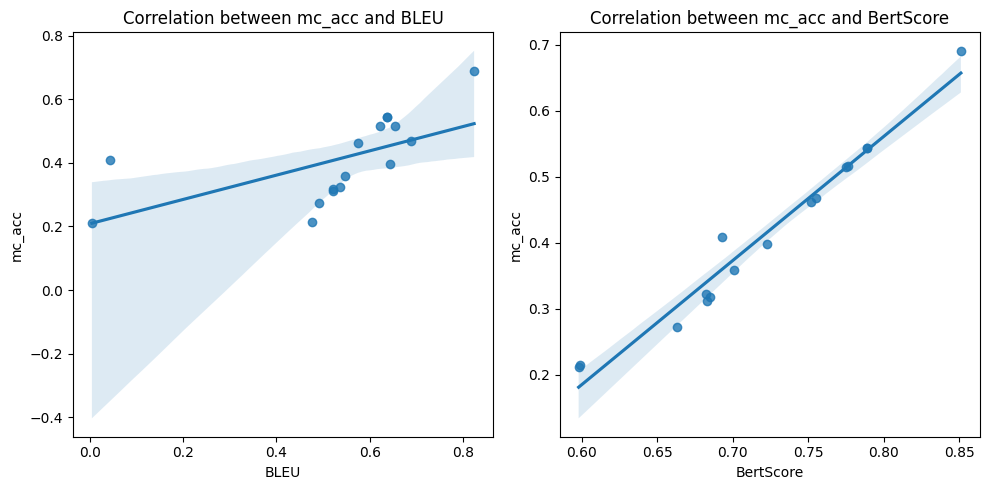

da


['person', '30', 'shallow', 'error', 'laptop', 'error', 'cooking', 'textured', 'surfing', 'jeans', 'you need to specify which', 'toys', 'animal', 'apple', 'laptop', 'angus', 'usa', 'desk shelf', 'daytime', 'running', 'birthday party', 'paper', 'cold weather', 'ball', 'mouse', 'ski', 'boeing 787', 'drinking water', 'transportation', 'could you please clarify your', 'ingredient1', 'error', 'online chat', 'table', 'on hat', 'need more context', 'liquid', 'soccer', 'swing', 'playing', 'home', 'plains', 'wool', 'dog', 'kitchen', 'error', 'meat', 'ice cream', 'black and white', 'chinese', 'airplane', 'safety', 'interacting', 'ice cream truck', 'to eat', 'bathroom', 'skateboarding', 'yes', 'you need to specify which', 'party', 'truck', 'you need to specify which', 'cocktail', 'free', 'right', 'france', 'christmas', 'elephant elephant elephant elephant', 'boat', 'basket', 'accident', 'none', 'biscuit', 'segway', 'safety reasons', 'wheels', 'error', 'unknown', 'streep', 'with frosting', 'anchor

/tmp/ipykernel_3003756/3215461061.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)


                      model task   bleu  bertscore  da_acc
0           BLIP 2 OPT 2.7B   da  0.016      0.292   0.050
1                  ViperGPT   da  0.011      0.647   0.169
2              LLaVA-1.5-7b   da  0.217      0.883   0.477
3       CLIP (Zero Shot) MM   da  0.155      0.470   0.005
4     CLIP (Contrastive) MM   da  0.361      0.568   0.076
5      CLIP (Classifier) MM   da  0.523      0.621   0.138
6                   ClipCap   da  0.256      0.701   0.203
7     ClipCap (with RN50x4)   da  0.475      0.683   0.196
8       Llama 3 8B Instruct   da  0.001      0.530   0.067
9   CLIP (Contrastive) UM-T   da  0.288      0.538   0.035
10   CLIP (Classifier) UM-T   da  0.429      0.592   0.080
11          BERT Classifier   da  0.336      0.570   0.055
12    CLIP (Zero Shot) UM-I   da  0.219      0.481   0.013
13  CLIP (Contrastive) UM-I   da  0.219      0.481   0.013
14   CLIP (Classifier) UM-I   da  0.293      0.517   0.034
15      ResNet (Classifier)   da  0.196      0.485   0.0

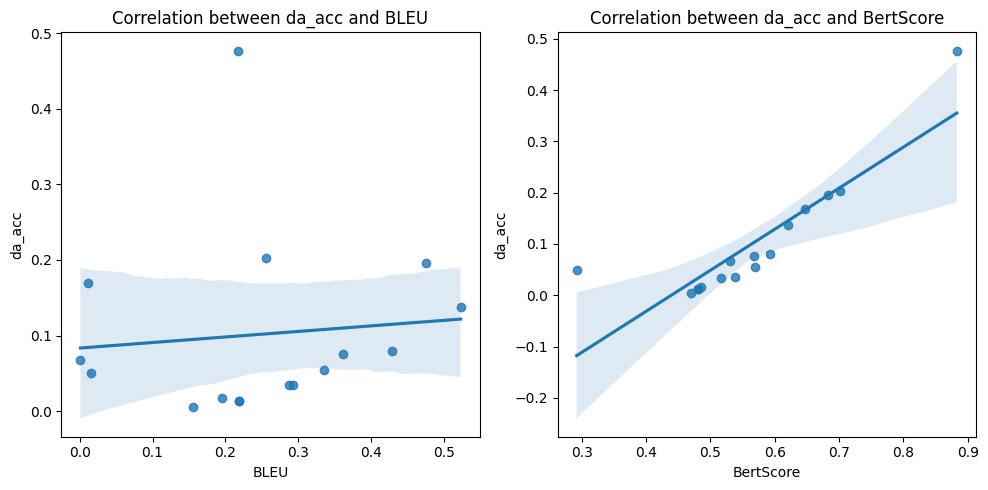

In [13]:
def format_string(s):
    # Convert to lowercase
    s = s.lower()
    
    # Remove punctuation
    s = re.sub(r'[^\w\s]', '', s)
    
    # Remove articles (a, an, the)
    s = re.sub(r'\b(a|an|the)\b', '', s)
    
    # Convert words to digits (if they are numbers)
    s = re.sub(r'\bzero\b', '0', s)
    s = re.sub(r'\bone\b', '1', s)
    s = re.sub(r'\btwo\b', '2', s)
    s = re.sub(r'\bthree\b', '3', s)
    s = re.sub(r'\bfour\b', '4', s)
    s = re.sub(r'\bfive\b', '5', s)
    s = re.sub(r'\bsix\b', '6', s)
    s = re.sub(r'\bseven\b', '7', s)
    s = re.sub(r'\beight\b', '8', s)
    s = re.sub(r'\bnine\b', '9', s)
    
    # Remove extra spaces
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

def load_jsonl_data(file_path):
    """Load data from a JSONL file into a list of dictionaries."""
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

def get_model_results_and_refs(val, task, results_dir, ref_path):
    """Retrieve model results and reference data for a given model and task."""
    fname = val['raw_results_fname']
    model_results_path = f"{results_dir}/formatted/{fname.replace('.json', '')}.jsonl"

    # Load model results and reference data
    model_results_data = load_jsonl_data(model_results_path)
    ref_data = load_jsonl_data(ref_path)

    # Extract predictions and references for the task
    preds = [entry[task] for entry in model_results_data]
    preds = [format_string(pred) if pred is not None else '' for pred in preds]
    refs = [next(iter(entry.values()))[task] for entry in ref_data]
    return preds, refs

def process_models(models, task, results_dir, ref_path):
    """Create a simple DataFrame of model metrics."""
    rows = []
    task_metric = 'mc_acc' if task == 'mc' else 'da_acc'
    for model, val in models.items():
        preds, refs = get_model_results_and_refs(val, task, results_dir, ref_path)
        
        if model == 'ViperGPT':
            print(preds)
            errors = sum([pred.lower() == 'error' for pred in preds])
            print ('viper', 1 - (errors / len(preds)))
        
        bleu_score = metrics._bleu(preds, refs)['bleu']
        _, _, bs_F1 = metrics._bert_score(preds, refs)
        
        task_metric_val = metrics._mc_accuracy(preds, refs) if task == 'mc' else metrics._da_accuracy(preds, refs)
        rows.append({
            'model': model,
            'task': task,
            'bleu': bleu_score,
            'bertscore': bs_F1.mean().item(),
            task_metric: task_metric_val
        })

    df = pd.DataFrame(rows)
    df.to_csv(f"{results_dir}/metrics.csv", index=False)
    return df

def plot_correlations(df, task_metric):
    """Plot correlations between task_metric and BLEU, and task_metric and BertScore."""
    plt.figure(figsize=(10, 5))
    
    # Plot correlation between task_metric and BLEU
    plt.subplot(1, 2, 1)
    sns.regplot(x='bleu', y=task_metric, data=df)
    plt.title(f'Correlation between {task_metric} and BLEU')
    plt.xlabel('BLEU')
    plt.ylabel(task_metric)

    # Plot correlation between task_metric and BertScore
    plt.subplot(1, 2, 2)
    sns.regplot(x='bertscore', y=task_metric, data=df)
    plt.title(f'Correlation between {task_metric} and BertScore')
    plt.xlabel('BertScore')
    plt.ylabel(task_metric)

    plt.tight_layout()
    plt.show()

# Loop through tasks and process each one
for task in TASKS:
    print(task)
    df = process_models(MODELS, task, RESULTS_DIR, f'{RESULTS_DIR}/gold_validation.jsonl')
    df = df.applymap(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)
    print(df)
    
    # Determine the task metric column name based on the task
    task_metric = 'mc_acc' if task == 'mc' else 'da_acc'
    
    # Plot correlations for the current task's DataFrame
    plot_correlations(df, task_metric)